In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
%matplotlib inline

## Linear Splines

Now we are going to try a very different approach to function approximation compared to what we did above with Lagrange Interpolation, though identical to how we developed the Trapezoid Method.  Instead of one global interpolating polynomial for given data $\left\{(x_{j},f_{j})\right\}^{N}_{j=0}$, we are going to use a piecewise defined function $S(x)$ where

$$
S(x) = \left\{ \begin{array}{rl} S_{0}(x) & x_{0}\leq x < x_{1} \\ S_{1}(x) & x_{1}\leq x < x_{2} \\ \vdots & \vdots \\ S_{n-1}(x) & x_{n-1}\leq x \leq x_{n} \end{array}\right.
$$

with the interpolation requirements

$$
S_{j}(x_{j}) = f_{j}, ~ j=0,\cdots,n-1, ~ S_{n-1}(x_{n}) = f_{n},
$$

and the continuity requirements at the interior points $\left\{x_{j}\right\}^{n-1}_{j=1}$

$$
S_{j}(x_{j+1}) = S_{j+1}(x_{j+1}), ~ j=0,\cdots,n-2.
$$

By choosing $S_{j}(x) = m_{j}(x-x_{j}) + f_{j}$, this continuity requirement gives us that 

$$
m_{j}(x_{j+1}-x_{j}) + f_{j} = f_{j+1},
$$

or 

$$
m_{j} = \frac{f_{j+1}-f_{j}}{x_{j+1}-x_{j}}, ~ j=0,\cdots,n-1.
$$

To implement this then, we use the following code.

In [25]:
def linear_spline(xvals,fvals,xquery):
    npts = xvals.size
    qpts = xquery.size
    svals = np.zeros(qpts)
    # Precompute the slopes
    mvals = (fvals[1:]-fvals[:(npts-1)])/(xvals[1:]-xvals[:(npts-1)])
    # Now find the appropriate interval for each query point
    for ll in range(qpts):
        for jj in range(npts - 1):
            if xvals[jj]<=xquery[ll] and xquery[ll]<xvals[jj+1]:
                svals[ll] = mvals[jj]*(xquery[ll]-xvals[jj]) + fvals[jj]
                break
            svals[ll] = mvals[npts-2]*(xquery[ll]-xvals[npts-2]) + fvals[npts-2]

    return svals

In [29]:
xquery = np.linspace(-1.,1.,int(1e3)+1)
ftrue = 1./(1.+xquery**2.)
xvals = xquery[::12]
fvals = ftrue[::12]

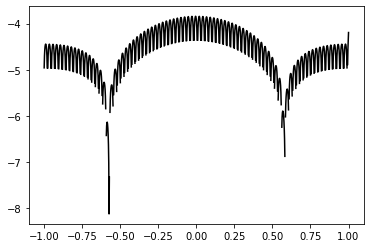

In [30]:
finterp = linear_spline(xvals,fvals,xquery)
plt.plot(xquery,np.ma.log10(np.abs(ftrue-finterp)),ls='-',color='k')

## Logical Indexing

In [49]:
def linear_spline_logical_indexing(xvals,fvals,xquery):
    npts = xvals.size
    qpts = xquery.size
    svals = np.zeros(qpts)
    # Precompute the slopes
    mvals = (fvals[1:]-fvals[:(npts-1)])/(xvals[1:]-xvals[:(npts-1)])
    # Now find the appropriate interval for each query point
    for ll in range(qpts):
        xvalslft = xvals <= xquery[ll]        
        jj = np.sum(xvalslft)
        if jj < npts-1:
            svals[ll] = mvals[jj-1]*(xquery[ll]-xvals[jj-1]) + fvals[jj-1]
        else:
            svals[ll] = mvals[npts-2]*(xquery[ll]-xvals[npts-2]) + fvals[npts-2]
    return svals

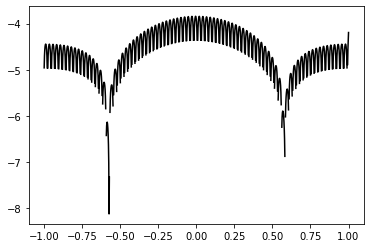

In [50]:
finterp_logical = linear_spline_logical_indexing(xvals,fvals,xquery)
plt.plot(xquery,np.ma.log10(np.abs(ftrue-finterp_logical)),ls='-',color='k')

## Cubic Splines

So, while linear splines clearly work, they do not do so in a terribly efficient way.  To improve on this then, as before, we start our discussion with a data set 

$$
\left\{x_{j},f_{j}\right\}_{j=0}^{n}.
$$

We now define our _cubic splines_ $S_{j}(x)$ to be third order polynomials, i.e. 

$$
S_{j}(x) = a_{j}(x-x_{j})^{3} + b_{j}(x-x_{j})^{2} + c_{j}(x-x_{j}) + d_{j},
$$

such that 

\begin{align}
S_{j}(x_{j}) = & f_{j}, ~ j=0,\cdots,n-1\\
S_{j}(x_{j+1}) = & S_{j+1}(x_{j+1}), ~ j=0,\cdots,n-2 \\
S'_{j}(x_{j+1}) = & S'_{j+1}(x_{j+1}), ~ j=0,\cdots,n-2 \\
S''_{j}(x_{j+1}) = & S''_{j+1}(x_{j+1}), ~ j=0,\cdots,n-2 
\end{align}

which is to say, we require that we interpolate the data, and the each spline as as its first and second derivatives be continuous at each node.  Finally, we require that 

$$
S_{n-1}(x_{n}) = f_{n}, ~ S''_{0}(x_{0})=0, ~ S''_{n-1}(x_{n}) = 0.
$$

We readily see then that $d_{j}= f_{j}$.  Define 

$$
\delta x_{j} = x_{j+1} -x_{j}, ~ \delta f_{j} = f_{j+1} - f_{j}.
$$

Then from above we get the system of equations for  $j=0,\cdots,n-2$

\begin{align}
a_{j}(\delta x_{j})^{2} + b_{j}\delta x_{j} + c_{j} = & \frac{\delta f_{j}}{\delta x_{j}},\\
3a_{j}(\delta x_{j})^{2} + 2b_{j}\delta x_{j} + c_{j} = & c_{j+1},\\
3a_{j}\delta x_{j} + b_{j} = & b_{j+1} 
\end{align}

The end point conditions give us

$$
a_{n-1}\left(\delta x_{n-1}\right)^{2} + b_{n-1}\delta x_{n-1} + c_{n-1} = \frac{\delta f_{n-1}}{\delta x_{n-1}},
$$

and

$$
b_{0}=0, ~ 3a_{n-1}\delta x_{n-1} + b_{n-1} = 0.
$$

Solving for $a_{j}$ gives us, 

$$
a_{j} = \frac{1}{\delta x_{j}^{2}}\left(\frac{\delta f_{j}}{\delta x_{j}} - c_{j} - b_{j}\delta x_{j}\right), ~ j=0,\cdots,n-1,
$$

and in turn we then find that 

\begin{align}
3\frac{\delta f_{j}}{\delta x_{j}} - b_{j}\delta x_{j} - 2c_{j} = & c_{j+1}, ~ j=0,\cdots,n-2\\
3\frac{\delta f_{j}}{(\delta x_{j})^{2}} - 3\frac{c_{j}}{\delta x_{j}} - 2b_{j} = & b_{j+1}, ~j=0,\cdots,n-2,
\end{align}

and

$$
c_{n-1} = \frac{\delta f_{n-1}}{\delta x_{n-1}} - \frac{2}{3}\delta x_{n-1}b_{n-1}.
$$

Likewise, solving for $c_{j}$ then gives us

$$
c_{j} = \frac{\delta f_{j}}{\delta x_{j}} - \frac{\delta x_{j}}{3}\left( 2b_{j} + b_{j+1}\right), ~ j=0,\cdots,n-2.
$$

Ultimately then, we arrive at the system of equations, for $j=1,\cdots,n-3$, 

$$
\frac{\delta x_{j}}{3} b_{j} + \frac{2}{3}\left(\delta x_{j} + \delta x_{j+1} \right)b_{j+1} + \frac{\delta x_{j+1}}{3} b_{j+2} = \frac{\delta f_{j+1}}{\delta x_{j+1}} - \frac{\delta f_{j}}{\delta x_{j}},
$$

and

$$
\frac{2}{3}\left(\delta x_{0} + \delta x_{1} \right)b_{1} + \frac{\delta x_{1}}{3} b_{2} = \frac{\delta f_{1}}{\delta x_{1}} - \frac{\delta f_{0}}{\delta x_{0}},
$$

and

$$
\frac{\delta x_{n-2}}{3} b_{n-2} + \frac{2}{3}\left(\delta x_{n-2} + \delta x_{n-1} \right)b_{n-1} = \frac{\delta f_{n-1}}{\delta x_{n-1}} - \frac{\delta f_{n-2}}{\delta x_{n-2}}.
$$

At this point, we should talk about solving the problem $A{\bf b}=\tilde{{\bf f}}$ where $A$ is a self-adjoint tridiagonal matrix.  In other words, defining the vectors ${\bf b}$ and $\tilde{{\bf f}}$ where

$$
{\bf b} = \begin{pmatrix} b_{1} \\ b_{2} \\ \vdots \\ b_{n-1} \end{pmatrix}, ~ \tilde{{\bf f}} = \begin{pmatrix} \frac{\delta f_{1}}{\delta x_{1}} - \frac{\delta f_{0}}{\delta x_{0}} \\ \frac{\delta f_{2}}{\delta x_{2}} - \frac{\delta f_{1}}{\delta x_{1}} \\ \vdots \\ \frac{\delta f_{n-1}}{\delta x_{n-1}} - \frac{\delta f_{n-2}}{\delta x_{n-2}}\end{pmatrix}
$$

we see that $A$ is an $(n-1)\times (n-1)$ symmetric ($A^{T}=A$) matrix where

$$
A = \begin{pmatrix} \frac{2}{3}(\delta x_{0} + \delta x_{1}) & \frac{1}{3}\delta x_{1} & &\\
\frac{1}{3}\delta x_{1} & \frac{2}{3}(\delta x_{1} + \delta x_{2}) & \frac{1}{3}\delta x_{2} &\\
 & & \ddots & & \\
 & & \frac{1}{3}\delta x_{n-3} & \frac{2}{3}(\delta x_{n-3} + \delta x_{n-2}) & \frac{1}{3}\delta x_{n-2}\\
 & & & \frac{1}{3}\delta x_{n-2} & \frac{2}{3}(\delta x_{n-2} + \delta x_{n-1})
\end{pmatrix}
$$

In code, we proceed as below.   

In [ ]:
def spline_maker(xvals,fvals,qvals):
    # m = fvals.size
    # note, from above, n = m-1
    
    n = fvals.size - 1
    df = fvals[1:]-fvals[0:n]
    dx = xvals[1:]-xvals[0:n]
    dfdx = df/dx
    svals = np.zeros(ivals.size)
    
    rhs = dfdx[1:] - dfdx[0:n-1]
    diag = 2./3.*(dx[1:] + dx[0:n-1])
    data = np.array([diag,dx[1:]/3.,dx[0:n-1]/3.])
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, n-1, n-1)
    bvec = spsolve(Amat,rhs)
    
    bvec = np.append(0.,bvec)
    
    cvec = dfdx - 2./3.*dx*bvec - dx/3.*np.append(bvec[1:],0.)
    avec = (dfdx - dx*bvec - cvec)/(dx**2.)
    
    for jj in range(1,n+1):
        
        indsr = qvals < xvals[jj] 
        indsl = qvals >= xvals[jj-1]
        inds = indsl*indsr
        
        dxloc = qvals[inds] - xvals[jj-1]
        svals[inds] = avec[jj-1]*dxloc**3. + bvec[jj-1]*dxloc**2. + cvec[jj-1]*dxloc + fvals[jj-1]
        
    return svals

Revisiting the example from above in which 

$$
f(x) = \frac{1}{1+x^{2}}, ~ -1\leq x \leq 1,
$$

we can now test our spline approximation scheme.  As we show, it can be very accurate, and while our arbitrary choice of enforcing zero curvature at the endpoints does cost us some amount of accuracy, we do not have anything resembling the problems we saw above with Lagrange interpolation.  Thus, splines offer us an accurate, efficient, and flexible means of interpolating data.  

In [ ]:
xvs = np.linspace(-1.,1.,int(1e3)+1)
fvs = 1./(1.+xvs**2.)
ivals = np.linspace(-.99,.99,int(5e3))
ftrue = 1./(1.+ivals**2.)

svals = spline_maker(xvs,fvs,ivals)
#plt.plot(ivals,svals,ls='-',color='k')
#plt.plot(ivals,ftrue,ls='--',color='r')
plt.plot(ivals,np.ma.log10(np.abs(ftrue-svals)))